In [1]:
import texplot
import pickle
import leaderbot as lb
import numpy as np
import matplotlib.pyplot as plt
with open('../benchmark/models_train_full.pkl', 'rb') as f:
    results = pickle.load(f)

models = results['models']
test_data = results['test_data']

model = models[22]  # Davidson Scaled (k conv = 0 and k tie = 0)

In [2]:
data = lb.load()

x = data['X']
y = data['Y']

In [3]:
m = np.max(x) + 1

W = np.ma.masked_array(np.zeros((m, m)), mask=True)
T = np.ma.masked_array(np.zeros((m, m)), mask=True)

for row in range(x.shape[0]):
    i, j = x[row, 0], x[row, 1]
    W[i, j] = y[row, 0]
    W[j, i] = y[row, 1]
    T[i, j] = y[row, 2]
    T[j, i] = y[row, 2]

rnk = model.rank()

W = W[rnk, :][:, rnk]
T = T[rnk, :][:, rnk]

Plot saved to "/home/sia/work/github/arenaranking/notebooks/counts.pdf".


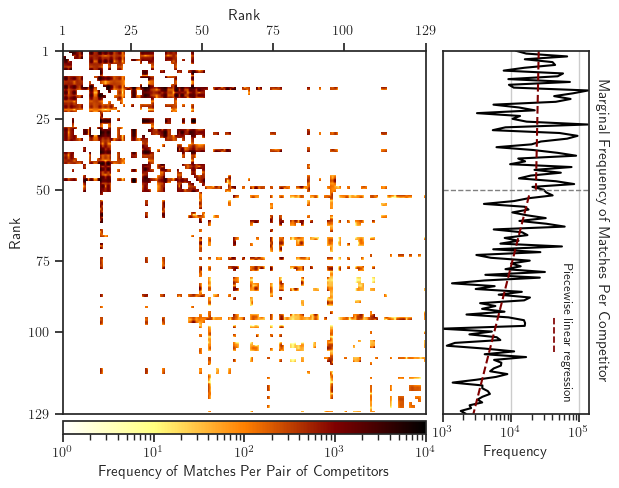

In [4]:
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

with texplot.theme(rc={'font.family': 'sans-serif'}, use_latex=True, font_scale=0.9):
    
    # Create the figure
    fig = plt.figure(figsize=(7, 5))
    
    # Define GridSpec layout with extra columns for spacing
    gs = GridSpec(2, 3, height_ratios=[20, 1], width_ratios=[4, 1, 0.5], hspace=0.02, wspace=0.02)
    
    # Main plot (ax1)
    ax1 = fig.add_subplot(gs[0, 0])
    C = W + W.T + T
    p0 = ax1.imshow(C, cmap=plt.cm.afmhot_r, norm=LogNorm())
    ax1.set_xticks([1, 25, 50, 75, 100, m])
    ax1.set_yticks([1, 25, 50, 75, 100, m])
    ax1.set_xlim([1, m])
    ax1.set_ylim([1, m])
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.set_xlabel('Rank')
    ax1.set_ylabel('Rank')
    
    # Colorbar for ax1 aligned exactly below ax1
    cax = fig.add_axes([
        ax1.get_position().x0,  # Match the left x-coordinate of ax1
        ax1.get_position().y0 - 0.04,  # Slightly below ax1
        ax1.get_position().width,  # Match the width of ax1
        0.025,  # Height of the colorbar
    ])
    cbar = fig.colorbar(p0, cax=cax, orientation='horizontal')
    cbar.set_label('Frequency of Matches Per Pair of Competitors')
    
    # Secondary plot (ax2)
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)  # Share the y-axis with ax1
    rng = np.arange(1, m + 1)
    nwin = np.ma.sum(W, axis=0)
    nlos = np.ma.sum(W, axis=1)
    ntie = np.ma.sum(T, axis=0)
    ntot = nwin + nlos + ntie
    
    ax2.plot(ntot, rng, color='black')
    ax2.set_xscale('log')
    ax2.set_xlabel('Frequency')
    ax2.set_title('Marginal Frequency of Matches Per Competitor', loc='right',
                  rotation=270, y=0.48, x=1.14, va='center', fontsize=11)
    ax2.set_ylim([1, m])
    ax2.set_xlim([1e3, 1.39e5])
    ax2.set_yticks([1, 25, 50, 75, 100, m])
    ax2.yaxis.set_visible(False)
    
    
    ax1.invert_yaxis()

    pos = ax2.get_position()
    ax2.set_position([pos.x0, pos.y0, pos.width * 1.5, pos.height])
    ax2.grid(axis='x')

    # ax1.axhline(y=50, color='gray', linestyle='--', linewidth=1)
    # ax1.axvline(x=50, color='gray', linestyle='--', linewidth=1)
    ax2.axhline(y=50, color='gray', linestyle='--', linewidth=1)

    # ========

    split1 = 55
    split2 = 50

    # Log-transform the x-axis data
    log_y1 = np.log10(ntot[:split1])
    log_y2 = np.log10(ntot[split2:])
    
    # Linear regression for the first segment
    coeffs1 = np.polyfit(rng[:split1], log_y1, deg=1)  # Fit y = a*log10(x) + b
    line1 = np.poly1d(coeffs1)
    
    # Linear regression for the second segment
    coeffs2 = np.polyfit(rng[split2:], log_y2, deg=1)  # Fit y = a*log10(x) + b
    line2 = np.poly1d(coeffs2)
    
    # Generate x-values for the lines (back to the original scale)
    x_range1 = np.linspace(rng[0], rng[split1-6], 100)
    x_range2 = np.linspace(rng[split2+1], rng[-1], 100)
    
    # Plot the piecewise regression lines
    l1, = ax2.plot(10.0**line1(x_range1), x_range1, color='maroon', linestyle='--',
             label='Piecewise linear regression')
    ax2.plot(10.0**line2(x_range2), x_range2, color='maroon', linestyle='--')
    
    # Add legend
    # ax2.legend(fontsize='x-small', loc='lower right')

    # ========

    handles = [l1]
    labels = ["Piecewise linear regression"]
    
    # Create rotated legend manually
    legend_x, legend_y = 0.76, 0.22  # Position of legend
    spacing = 0.04  # Spacing between entries
    
    for i, (handle, label) in enumerate(zip(handles, labels)):
        # Line segment for legend
        ax2.plot(
        [legend_x, legend_x],
        [legend_y - i * spacing - 0.05, legend_y - i * spacing + 0.05],  # Vary y for length
        color=handle.get_color(),
        lw=1.25,
        clip_on=False,
        transform=ax2.transAxes,
        linestyle='--',
    )
    
        # Rotated text for legend
        ax2.text(
            legend_x + spacing + 0.05,
            legend_y - i * 0.2,
            label,
            rotation=-90,
            va="center",
            ha="center",
            transform=ax2.transAxes,
            fontsize=9,
        )
    
    texplot.show_or_save_plot(plt, default_filename='counts.pdf',
                              transparent_background=True, dpi=200,
                              show_and_save=True, verbose=True)